In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
DATA_ROOT = "E:\\Datasets\\Br35H"
AUTOTUNE = tf.data.AUTOTUNE

## Load necessary functions

In [3]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return int(one_hot)

In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize and norm the image
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
def plot_acc(hist, title: str):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
def plot_loss(hist, title: str):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Visiaulize samples from dataset

In [6]:
class_names = ['0', '1', '2', '3']
map_dict = {'0': '10', '1': '30', '2': '50', '3': '70'}

rot_train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.2.0\\train\\*\\*", shuffle=False)
rot_train_dataset = rot_train_dataset.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
rot_train_dataset = rot_train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(1)

In [7]:
sample_dict = {'0': [], '1': [], '2': [], '3': []}
iterator=iter(rot_train_dataset)

for _ in range(500):
    sample = next(iterator)
    image = sample[0].numpy().reshape(128,128,3)
    label = tf.math.argmax(sample[1], axis=1).numpy()[0]
    sample_dict[str(label)].append(image)

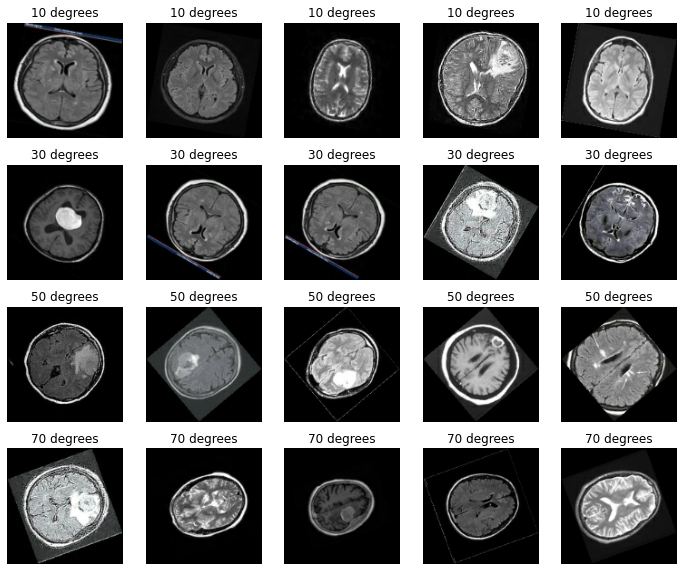

In [8]:
plt.figure(figsize=(12,10))
i=1
for row in range(4):
    for column in range(5):
        plt.subplot(4, 5, i)
        image = sample_dict[str(row)][column]
        rot_angle = map_dict[str(row)]
        plt.imshow(image)
        plt.title(f'{rot_angle} degrees')
        plt.axis('off')
        i += 1

## Load datasets

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
MINI_BATCH_SIZE = 32
class_names = ['0', '1', '2', '3']

rot_train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.2.0\\train\\*\\*", shuffle=False)
rot_train_dataset = rot_train_dataset.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
rot_train_dataset = rot_train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

rot_val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.2.0\\val\\*\\*", shuffle=False)
rot_val_dataset = rot_val_dataset.shuffle(len(rot_val_dataset), reshuffle_each_iteration=False)
rot_val_dataset = rot_val_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

In [ ]:
MINI_BATCH_SIZE = 32
class_names = ['0', '1']

train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.0.0\\train\\*\\*", shuffle=False)
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=False)
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.0.0\\val\\*\\*", shuffle=False)
val_dataset = val_dataset.shuffle(len(val_dataset), reshuffle_each_iteration=False)
val_dataset = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\data_v1.0.0\\test\\*\\*", shuffle=False)
test_dataset = test_dataset.shuffle(len(test_dataset), reshuffle_each_iteration=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

## Initialize and train model for rotation angle classifiction pre-text task

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

IMG_SIZE=128
NUM_CLASSES=4

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)

    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model()
# model.summary()

In [ ]:
history = model.fit(rot_train_dataset, epochs=1, validation_data=rot_val_dataset)

In [ ]:
plot_acc(history, "pre-text task model accuracy")
plot_loss(history, "pre-text task model loss ")

In [ ]:
model.save("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.2.0")

## Fine-tune pretrained model for brain tumor classification task

In [ ]:
model = tf.keras.models.load_model("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.2.0")

In [ ]:
# Reinitializing dense classification layer
inputs = model.input

x = model.layers[-2].output
outputs = layers.Dense(2, activation="softmax", name="pred")(x)

model2 = tf.keras.Model(inputs, outputs, name="EfficientNet_2")

# Freezing the Convolutional Layers while keeping Dense layers as Trainable
for layer in model2.layers:
    if not (layer.name in ['pred', 'batch_normalization_1']):
        layer.trainable=False
    else:
        layer.trainable=True

# Compiling the model
model2.compile(loss="categorical_crossentropy",  optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
# model2.summary()

In [ ]:
# Training the model on Downstream Task
history2 = model2.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [ ]:
model2.evaluate(test_dataset)

In [ ]:
plot_acc(history2, "fine-tuned model accuracy")
plot_loss(history2, "fine-tuned model loss ")

In [ ]:
model2.save("C:\\Users\\Student\\Desktop\\Kamilio\\models\\model_v1.0.1")